<a href="https://colab.research.google.com/github/Nusserle/LieDetection/blob/master/LieDetectionEEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from scipy import signal

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

plt.rcParams['figure.figsize'] = (18, 6)

Using TensorFlow backend.


In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd drive/My Drive/Shared/BagOfLies/
df = pd.read_csv("Annotations.csv")
df.head()

/content/drive/My Drive/Shared/BagOfLies


,eeg,gaze,image,run,truth,usernum,video
0,./Finalised/User_0/run_0/EEG.csv,./Finalised/User_0/run_0/Gaze.csv,./Finalised/User_0/run_0/image.csv,0,1,0,./Finalised/User_0/run_0/video.mp4
1,./Finalised/User_0/run_1/EEG.csv,./Finalised/User_0/run_1/Gaze.csv,./Finalised/User_0/run_1/image.csv,1,0,0,./Finalised/User_0/run_1/video.mp4
2,./Finalised/User_0/run_2/EEG.csv,./Finalised/User_0/run_2/Gaze.csv,./Finalised/User_0/run_2/image.csv,2,0,0,./Finalised/User_0/run_2/video.mp4
3,./Finalised/User_0/run_3/EEG.csv,./Finalised/User_0/run_3/Gaze.csv,./Finalised/User_0/run_3/image.csv,3,0,0,./Finalised/User_0/run_3/video.mp4
4,./Finalised/User_0/run_4/EEG.csv,./Finalised/User_0/run_4/Gaze.csv,./Finalised/User_0/run_4/image.csv,4,0,0,./Finalised/User_0/run_4/video.mp4


In [0]:
df_eeg = df[['eeg', 'truth']].dropna().reset_index()

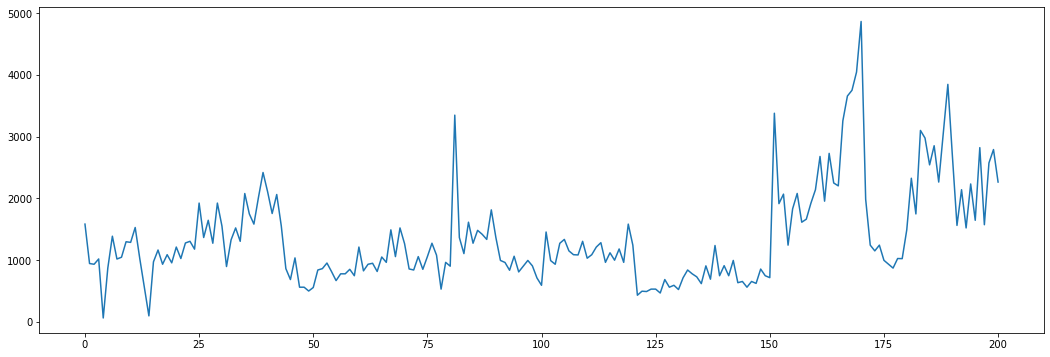

In [82]:
lengths = []
for i, eeg in df_eeg.iterrows():
  lengths.append(pd.read_csv(eeg[1]).iloc[:,1:-1].shape[0])
plt.plot(lengths)

(array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 2., 4., 6., 0., 2., 3., 2., 3., 2., 3., 4., 3., 0., 4., 7., 5.,
        3., 3., 7., 8., 6., 2., 7., 5., 5., 2., 0., 3., 2., 3., 1., 4., 8.,
        4., 3., 0., 3., 1., 1., 1., 0., 3., 3., 1., 4., 3., 2., 2., 1., 0.,
        0., 0., 3., 0., 1., 1., 0., 0., 0., 4., 1., 0., 1., 1., 0., 4., 0.,
        1., 2., 0., 0., 1., 1., 3., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([  59.  ,   83.04,  107.08,  131.12,  155.16,  179.2 ,  203.24,
         227.28,  251.32,  275.

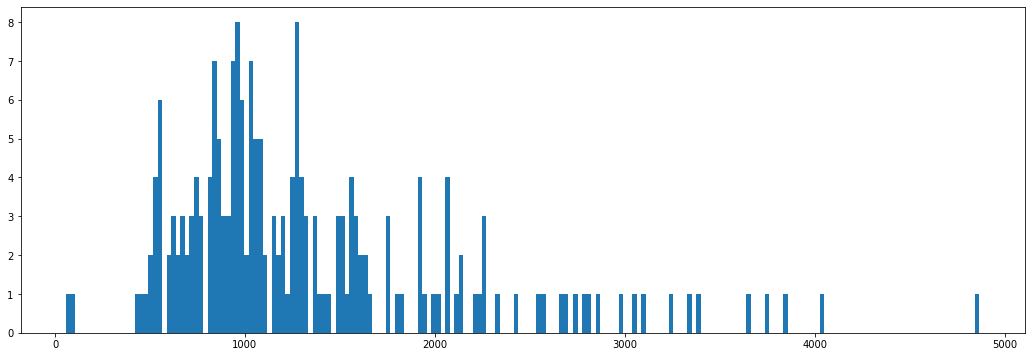

In [12]:
plt.hist(lengths, bins=200)

In [15]:
df_eeg.head()

,index,eeg,truth
0,0,./Finalised/User_0/run_0/EEG.csv,1
1,1,./Finalised/User_0/run_1/EEG.csv,0
2,2,./Finalised/User_0/run_2/EEG.csv,0
3,3,./Finalised/User_0/run_3/EEG.csv,0
4,4,./Finalised/User_0/run_4/EEG.csv,0


In [14]:
df_curr = pd.read_csv(df_eeg.iloc[2,:][1]).iloc[:,1:-1]
df_curr

,F3 Value,F3 Quality,FC5 Value,5C5 Quality,F7 Value,F7 Quality,T7 Value,T7 Quality,P7 Value,P7 Quality,O1 Value,O1 Quality,O2 Value,O2 Quality,P8 Value,P8 Quality,T8 Value,T8 Quality,F8 Value,F8 Quality,AF4 Value,AF4 Quality,FC6 Value,FC6 Quality,F4 Value,F4 Quality,X Value,Y Value
0,-99,0,-116,0,-119,0,-92,0,-113,0,-121,0,-145,0,-144,0,-110,0,-87,0,-99,0,-10,0,-83,0,21,24
1,-117,0,-122,0,-124,0,-71,0,-108,0,-122,0,-110,0,-99,0,-100,0,-111,0,-126,0,-159,0,-79,0,22,24
2,-116,0,-119,0,-122,0,-89,0,-118,0,-121,0,-125,0,-118,0,-102,0,-103,0,-116,0,-135,0,-82,0,21,24
3,-114,0,-122,0,-114,0,-83,0,-109,0,-119,0,-89,0,-110,0,-97,0,-123,0,-130,0,-198,0,-87,0,21,24
4,-108,0,-116,0,-121,0,-89,0,-89,0,-121,0,-84,0,-102,0,-105,0,-102,0,-110,0,-142,0,-81,0,21,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,-112,2896,-106,0,-127,24,-64,2520,-101,136,-120,16,-99,1648,-116,2528,-102,24,-115,5760,-114,2984,-111,1944,-84,360,21,24
938,-127,2896,-113,0,-120,24,-67,2520,-130,136,-125,16,-135,1648,-143,2528,-101,24,-131,5760,-126,2984,-158,1944,-91,360,21,24
939,-113,2896,-122,0,-117,24,-65,2520,-113,136,-115,16,-159,1648,-155,2528,-101,24,-115,4712,-112,2984,-180,1944,-85,360,21,24
940,-100,2896,-111,0,-124,24,-61,2520,-85,136,-107,16,-120,1648,-121,2528,-101,24,-99,4712,-94,2984,-151,1944,-79,360,21,24


In [0]:
# Filter EEG table only for values (except for X and Y Value)
# What is Quality? and X Value and Y Value
df_filtered = df_curr.loc[:, df_curr.columns.str.contains('Value')]
df_filtered = df_filtered.iloc[:,:-2]

In [69]:
df_filtered

,F3 Value,FC5 Value,F7 Value,T7 Value,P7 Value,O1 Value,O2 Value,P8 Value,T8 Value,F8 Value,AF4 Value,FC6 Value,F4 Value
0,-119,-100,-113,-105,-118,-125,-95,-122,-107,-116,-120,-102,-120
1,-129,-122,-118,-103,-139,-159,-80,-12,-113,-122,-114,-64,-123
2,-132,-121,-123,-123,-138,-146,-88,-21,-134,-120,-122,-69,-124
3,-123,-145,-124,-130,-143,-150,-97,-32,-179,-124,-134,-90,-121
4,-133,-156,-119,-116,-147,-149,-90,-26,-171,-125,-138,-94,-121
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258,-122,-117,-119,-118,-111,-110,-46,-40,-89,-128,-244,-89,-127
2259,-113,-124,-119,-120,-109,-105,-59,-65,-113,-128,-247,-108,-122
2260,-118,-117,-126,-105,-111,-109,-60,-57,-113,-124,-242,-103,-130
2261,-109,-118,-117,-108,-115,-127,-63,-48,-119,-125,-243,-104,-138


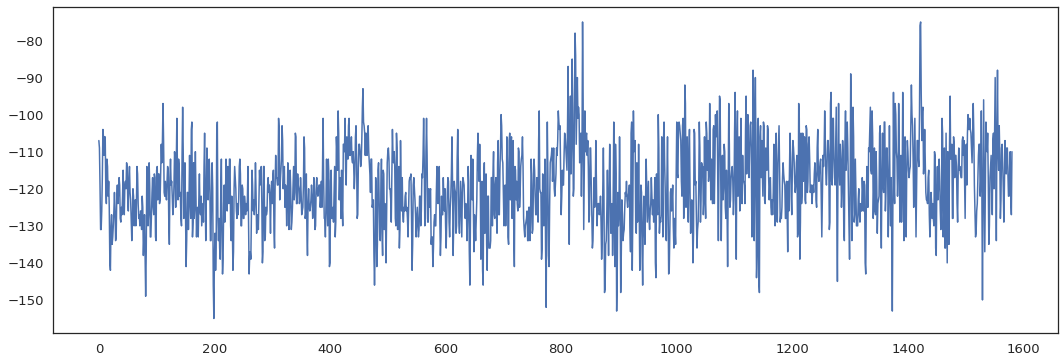

In [0]:
# EEG Signal from channel F3 with noise
f3_channel_eeg = df_filtered.iloc[:,:1]
plt.plot(f3_channel_eeg)

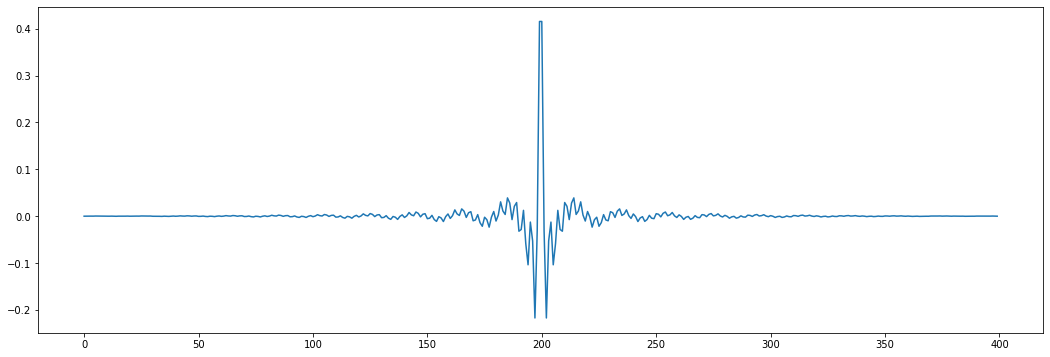

In [6]:
# Filter
filter = signal.firwin(400, [0.1, 0.6], pass_zero=False)
plt.plot(filter)
plt.show()

In [0]:
# Normalized values
data_norm_to_0_1 = [number/scipy.linalg.norm(f3_channel_eeg.squeeze()) for number in f3_channel_eeg.squeeze()]

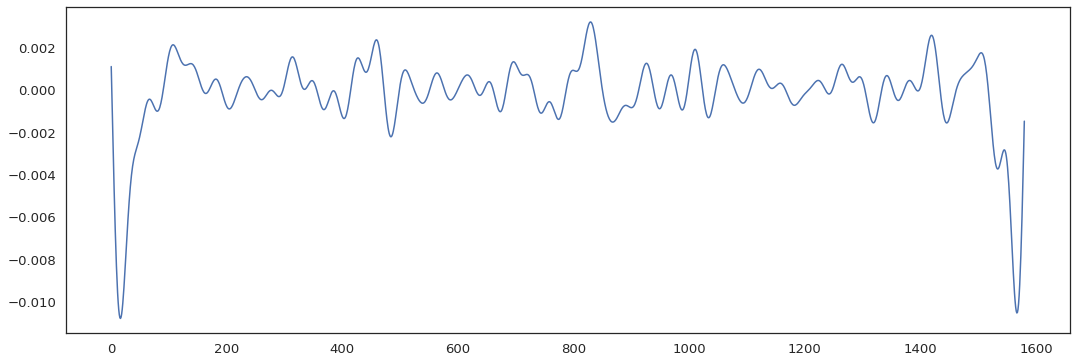

In [0]:
# Applied filter to normalized signal
filter = signal.firwin(400, [0.01, 0.06], pass_zero=False)
filtered_and_normalized = signal.convolve(data_norm_to_0_1, filter, mode="same")
plt.plot(filtered_and_normalized)

In [84]:
df_eeg.head()

,index,eeg,truth
0,0,./Finalised/User_0/run_0/EEG.csv,1
1,1,./Finalised/User_0/run_1/EEG.csv,0
2,2,./Finalised/User_0/run_2/EEG.csv,0
3,3,./Finalised/User_0/run_3/EEG.csv,0
4,4,./Finalised/User_0/run_4/EEG.csv,0


In [0]:
import scipy

In [8]:
data = []
current_max_dimension = 0
for i, eeg in df_eeg.iterrows():
  df_curr = pd.read_csv(eeg[1]).iloc[:,1:-1]
  if df_curr.shape[0] > current_max_dimension:
    current_max_dimension = df_curr.shape[0]
print(current_max_dimension)

data = np.zeros((df_eeg.shape[0], current_max_dimension * sum(df_curr.columns.str.contains('Value'))))
print(data.shape)
label = []
for i, eeg in df_eeg.iterrows():
  if i % 20 == 0:
    print(i)
  df_curr = pd.read_csv(eeg[1]).iloc[:,1:-1]
  df_curr = df_curr.apply(lambda x: pd.to_numeric(x, errors = 'coerce')).dropna()
  df_curr = df_curr.loc[:, df_curr.columns.str.contains('Value')]
  data_vector = np.asarray([])
  for col in df_curr:
    data_norm_to_0_1 = [number/scipy.linalg.norm(df_curr[col].squeeze()) for number in df_curr[col].squeeze()]
    filtered_and_normalized = signal.convolve(data_norm_to_0_1, filter, mode="same")
    data_vector = np.asarray(list(data_vector) + list(filtered_and_normalized))
  for j, el in enumerate(data_vector):
    data[i][j] = data_vector[j]
  
  #x = df_cleared.values #returns a numpy array
  #min_max_scaler = preprocessing.MinMaxScaler()
  #x_scaled = min_max_scaler.fit_transform(x)
  #for k, row in enumerate(x_scaled):
  #  for j, val in enumerate(row):
  #    if j > 0:
  #      pass
  #    else:
  #      data[i][k][j] = val
  label.append(eeg[2])
label = np.asarray(label)

4867
(201, 73005)
0
20
40
60
80
100
120
140
160
180
200


In [109]:
print(data)

[[ 1.40250523e-03 -7.86911475e-03 -8.85193769e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.91561202e-03 -1.21230694e-02 -1.39845007e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.46577263e-04 -1.53955240e-02 -1.51189399e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-8.30586341e-04 -8.84080165e-03 -7.25090219e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.19716815e-05 -7.66001848e-03 -6.92906534e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 8.01234914e-04 -8.67118267e-03 -8.84198433e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [110]:
print(data.shape)
print(label.shape)

(201, 73005)
(201,)


In [34]:
new_data = []
for el in data:
  new = el.flatten()
  new_data.append(new)
new_data = np.asarray(new_data)
print(new_data.shape)
data = new_data

(201, 4867)


In [0]:
X_train = data[:150]
y_train = label[:150]
#X_val = data[120:150]
#y_val = label[120:150]
X_test = data[150:]
y_test = label[150:]

In [36]:
print(X_train)

[[0.6        0.575      0.45       ... 0.         0.         0.        ]
 [0.71428571 0.39285714 0.41071429 ... 0.         0.         0.        ]
 [0.36842105 0.1754386  0.28070175 ... 0.         0.         0.        ]
 ...
 [0.71356784 0.55778894 0.59296482 ... 0.         0.         0.        ]
 [0.48679868 0.97607261 0.97772277 ... 0.         0.         0.        ]
 [0.61724501 0.60672976 0.61093586 ... 0.         0.         0.        ]]


In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
#dtc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, verbose=1)
dtc = DecisionTreeClassifier()
dtc_model = dtc.fit(X_train, y_train)

In [11]:
preds = dtc_model.predict(X_test)
accuracy_score(y_test, preds)

0.6274509803921569

In [0]:
model = models.Sequential()
model.add(layers.Dense(73005, activation='relu' ,input_shape=(73005,)))
#model.add(layers.Dense(4869, activation='sigmoid'))
model.add(layers.Dense(20000, activation='relu'))
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train,
                    y_train,
                    epochs=30,
                    batch_size=20,
                    validation_data=(X_val, y_val), verbose=1)

Train on 120 samples, validate on 30 samples
Epoch 1/30


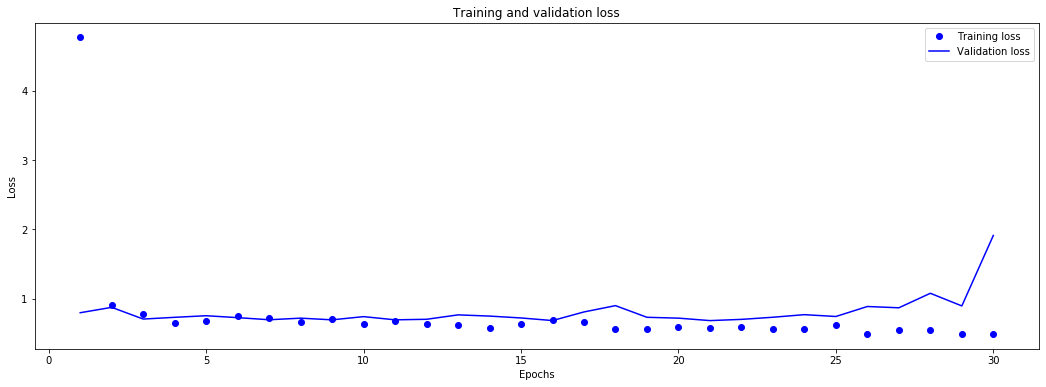

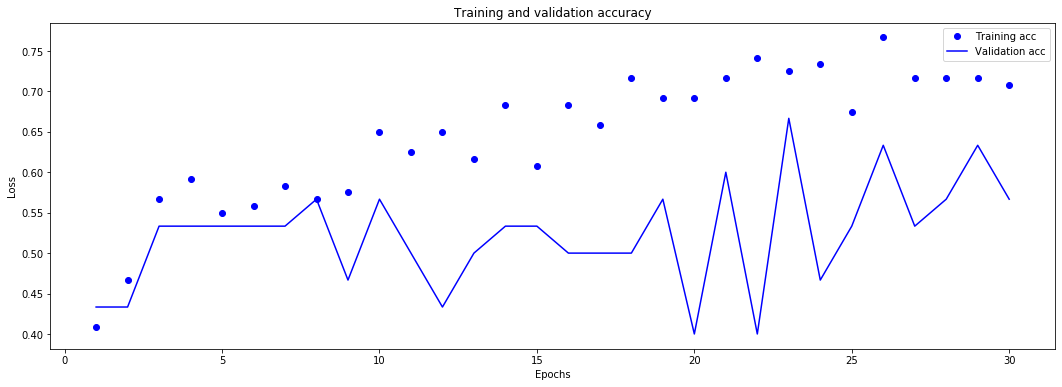

In [54]:
# Loss plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(test_acc)

51/51 [==============================] - 0s 200us/step
0.45098039332558126


In [0]:
model2 = models.Sequential()
#model2.add(layers.LSTM(57, activation='tanh' ,input_shape=(57,300,)))
model2.add(layers.Dense(57, activation='relu' ,input_shape=(57,300,)))
#model.add(layers.Conv1D(64, 5, activation='relu',input_shape=(57,300,)))
#model.add(layers.GlobalMaxPooling1D())
#model.add(layers.GRU(64, activation='tanh', input_shape=(57,300,)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(38, activation='relu'))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['acc'])